In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Import necessary libraries

In [4]:
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt

### Load Data

In [8]:
df = pd.read_csv("./directory/emails.csv") #"/kaggle/input/enron-email-dataset/emails.csv")

### Data Exploration

In [9]:
# view first 5 rows of the dataset
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [10]:
# get shape of the data
df.shape

(517401, 2)

In [11]:
# a sample email
print(df.loc[1]['message'])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

In [12]:
# transform the email into correct format
message = df.loc[1]['message']
e = email.message_from_string(message)

e.items()

[('Message-ID', '<15464986.1075855378456.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 4 May 2001 13:51:00 -0700 (PDT)'),
 ('From', 'phillip.allen@enron.com'),
 ('To', 'john.lavorato@enron.com'),
 ('Subject', 'Re:'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Phillip K Allen'),
 ('X-To', 'John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', "\\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail"),
 ('X-Origin', 'Allen-P'),
 ('X-FileName', 'pallen (Non-Privileged).pst')]

In [13]:
# get date
e.get('Date')

'Fri, 4 May 2001 13:51:00 -0700 (PDT)'

In [14]:
# show message body
e.get_payload()

"Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"

### Extract headers

In [15]:
# now we add those fields into our 'df' dataframe
def get_field(field, messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get(field))
    return column

In [16]:
df['date'] = get_field("Date", df['message'])
df['subject'] = get_field("Subject", df['message'])
df['X-Folder'] = get_field("X-Folder", df['message'])
df['X-From'] = get_field("X-From", df['message'])
df['X-To'] = get_field("X-To", df['message'])
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall


### Extract Message Body

In [17]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['body'] = body(df['message'])
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!


### Employee Names

In [18]:
df['file'][:10]

0       allen-p/_sent_mail/1.
1      allen-p/_sent_mail/10.
2     allen-p/_sent_mail/100.
3    allen-p/_sent_mail/1000.
4    allen-p/_sent_mail/1001.
5    allen-p/_sent_mail/1002.
6    allen-p/_sent_mail/1003.
7    allen-p/_sent_mail/1004.
8     allen-p/_sent_mail/101.
9     allen-p/_sent_mail/102.
Name: file, dtype: object

In [19]:
def employee(file):
    column = []
    for string in file:
        column.append(string.split("/")[0])
    return column

df['employee'] = employee(df['file'])
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!,allen-p


### Look into X-Folder

In [20]:
print("number of folders: ", df.shape[0])
print("number of unique folders: ", df['X-Folder'].unique().shape[0])

number of folders:  517401
number of unique folders:  5336


In [21]:
unique_emails = pd.DataFrame(df['X-Folder'].value_counts())
unique_emails.reset_index(inplace=True)


unique_emails.columns = ['folder_name', 'count']
# top 20 folders
unique_emails.iloc[:20,:]

,folder_name,count
0,\Kay_Mann_June2001_1\Notes Folders\All documents,6639
1,\Tanya_Jones_Dec2000\Notes Folders\All documents,5934
2,\Jeff_Dasovich_June2001\Notes Folders\All docu...,5637
3,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,5211
4,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,5066
5,\Kay_Mann_June2001_2\Notes Folders\Discussion ...,4956
6,\Jeff_Dasovich_Dec2000\Notes Folders\All docum...,4660
7,\Kay_Mann_June2001_3\Notes Folders\Sent,4440
8,\Kay_Mann_June2001_4\Notes Folders\'sent mail,4220
9,\Mark_Taylor _Dec_2000\Notes Folders\All docum...,4022


### Visualize top 20 folders

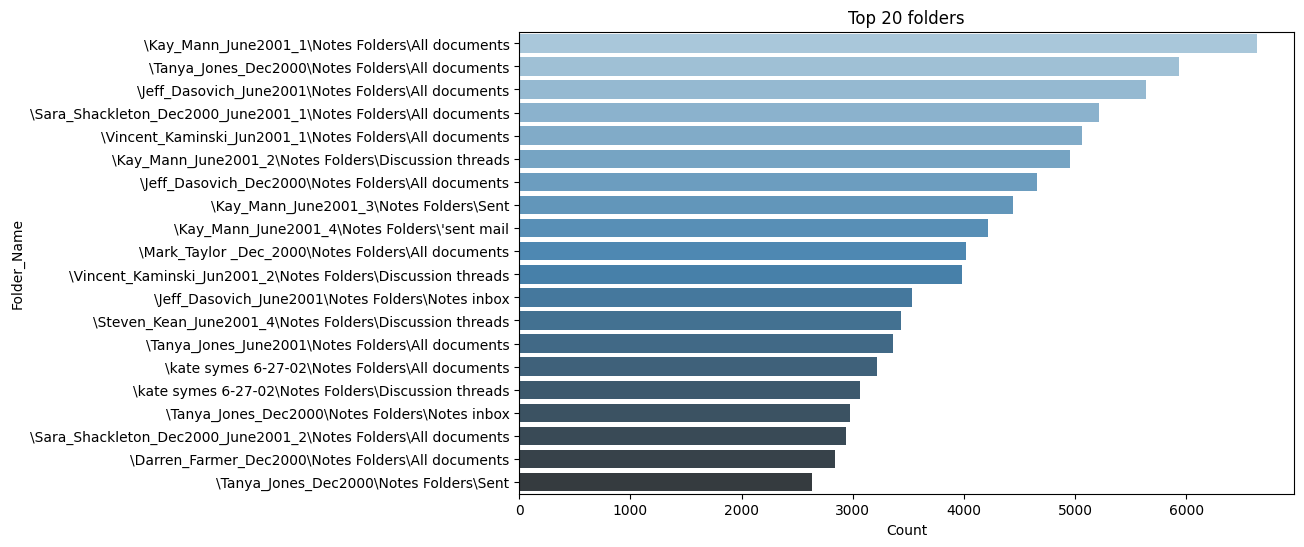

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='folder_name', data=unique_emails.iloc[:20, :], palette="Blues_d")
plt.title("Top 20 folders")
plt.xlabel("Count")
plt.ylabel("Folder_Name")
plt.show()

**Let's see top 20 highest email sender employee**

In [23]:
top_20 = pd.DataFrame(df['employee'].value_counts()[:20])
top_20.reset_index(inplace=True)
top_20.columns = ["Employee_name", "Counts"]
top_20

,Employee_name,Counts
0,kaminski-v,28465
1,dasovich-j,28234
2,kean-s,25351
3,mann-k,23381
4,jones-t,19950
5,shackleton-s,18687
6,taylor-m,13875
7,farmer-d,13032
8,germany-c,12436
9,beck-s,11830


**Visualize top 20 highest email sender employees**

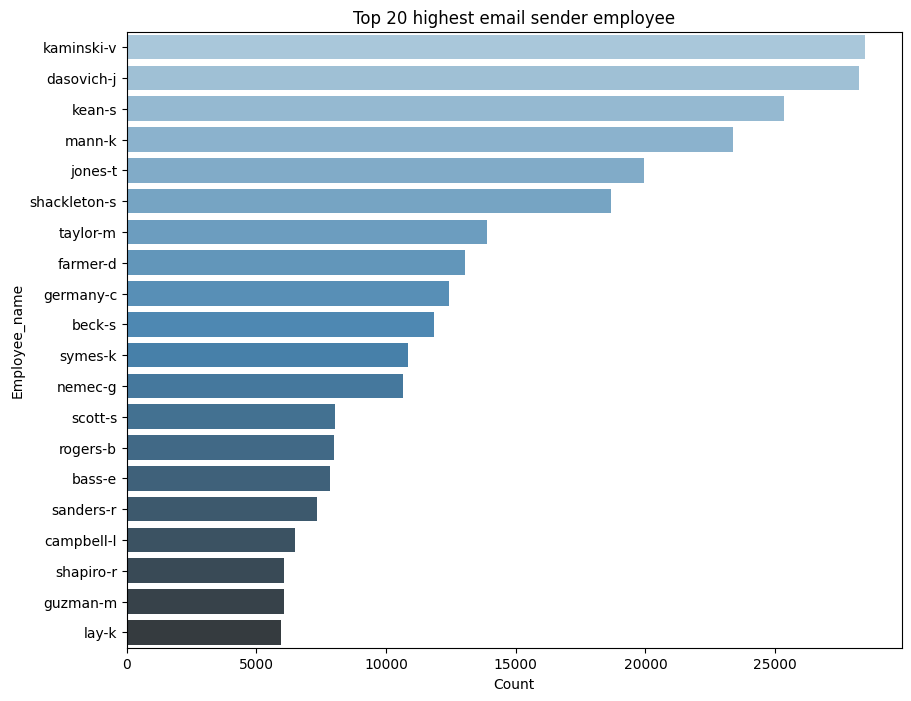

In [24]:
plt.figure(figsize=(10,8))

sns.barplot(y="Employee_name", x="Counts", data=top_20, palette="Blues_d")
plt.title("Top 20 highest email sender employee")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()

## Data Cleaning and Transformation

**date : column**

In [25]:
import datetime
from dateutil import parser

# this is sample example
x = parser.parse("Fri, 4 May 2001 13:51:00 -0700 (PDT)")
print(x.strftime("%d-%m-%Y %H:%M:%S"))

04-05-2001 13:51:00


In [26]:
def change_type(dates):
    column = []
    
    for date in dates:
        column.append(parser.parse(date).strftime("%d-%m-%Y %H:%M:%S"))
    return column

df['date'] = change_type(df['date'])
df.head(2)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,14-05-2001 16:39:00,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,04-05-2001 13:51:00,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p


**Column : X-Folder**

In [27]:
print(df['X-Folder'][0])

# we only want last folder name
df['X-Folder'][0].split("\\")[-1]

\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail


"'Sent Mail"

In [28]:
def preprocess_folder(folders):
    column = []
    for folder in folders:
        if (folder is None or folder == ""):
            column.append(np.nan)
        else:
            column.append(folder.split("\\")[-1].lower())
    return column

df['X-Folder'] = preprocess_folder(df['X-Folder'])
df.head(2)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,14-05-2001 16:39:00,,'sent mail,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,04-05-2001 13:51:00,Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p


In [29]:
# count unique folders
print("Unique Foldes: ", len(df['X-Folder'].unique()))

# view some of them
df['X-Folder'].unique()[0:20]

Unique Foldes:  1782


array(["'sent mail", 'all documents', 'contacts', 'deleted items',
       'discussion threads', 'inbox', 'notes inbox', 'sent items', 'sent',
       'straw', '2000 conference', 'active international', 'avaya', 'bmc',
       'bridge', 'bristol babcock', 'colleen koenig', 'compaq',
       'computer associates', 'continental airlines'], dtype=object)

**Replace empty missing values in subject with np.nan**

In [30]:
def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan) 
        else:
            column.append(val)
    return column

In [31]:
df['subject'] = replace_empty_with_nan(df['subject'])
df['X-To'] = replace_empty_with_nan(df['X-To'])

In [32]:
df.isnull().sum()

file            0
message         0
date            0
subject     19187
X-Folder       29
X-From         29
X-To         9153
body            0
employee        0
dtype: int64

In [33]:
# calculate percentage of missing values
miss = df.isnull().sum()
miss = miss[miss>0]
miss = miss / df.shape[0]
miss

subject     0.037083
X-Folder    0.000056
X-From      0.000056
X-To        0.017690
dtype: float64

In [34]:
# drop missing value rows
df.dropna(axis=0, inplace=True)

In [35]:
df.isnull().sum(), df.shape

(file        0
 message     0
 date        0
 subject     0
 X-Folder    0
 X-From      0
 X-To        0
 body        0
 employee    0
 dtype: int64,
 (489236, 9))

In [36]:
df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body,employee
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,04-05-2001 13:51:00,Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,18-10-2000 03:00:00,Re: test,'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!,allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,31-08-2000 05:07:00,Re: Hello,'sent mail,Phillip K Allen,Greg Piper,Let's shoot for Tuesday at 11:45.,allen-p


Drop the following columns:
- file
- message
- date
- X-From
- X-To
- employee

In [37]:
cols_to_drop = ['file','message','date','X-From','X-To','employee']

In [38]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [39]:
df.head()

,subject,X-Folder,body
1,Re:,'sent mail,Traveling to have a business meeting takes the...
2,Re: test,'sent mail,test successful. way to go!!!
4,Re: Hello,'sent mail,Let's shoot for Tuesday at 11:45.
5,Re: Hello,'sent mail,"Greg,\n\n How about either next Tuesday or Thu..."
7,Re: PRC review - phone calls,'sent mail,any morning between 10 and 11:30


In [40]:
# save the data
df.to_csv("cleaned_data.csv", index=False)